In [18]:
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [19]:
# Load train & test sets
train_df = pd.read_csv("UNSW_NB15_MODELS/UNSW_NB15_training-set.csv")
test_df  = pd.read_csv("UNSW_NB15_MODELS/UNSW_NB15_testing-set.csv")

train_df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [20]:
train_df.info()
train_df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 175341 non-null  int64  
 1   dur                175341 non-null  float64
 2   proto              175341 non-null  object 
 3   service            175341 non-null  object 
 4   state              175341 non-null  object 
 5   spkts              175341 non-null  int64  
 6   dpkts              175341 non-null  int64  
 7   sbytes             175341 non-null  int64  
 8   dbytes             175341 non-null  int64  
 9   rate               175341 non-null  float64
 10  sttl               175341 non-null  int64  
 11  dttl               175341 non-null  int64  
 12  sload              175341 non-null  float64
 13  dload              175341 non-null  float64
 14  sloss              175341 non-null  int64  
 15  dloss              175341 non-null  int64  
 16  si

id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat 

In [21]:
cat_cols = train_df.select_dtypes(include=['object']).columns

for col in cat_cols:
    le = LabelEncoder()
    combined = pd.concat([train_df[col], test_df[col]], axis=0).astype(str)
    le.fit(combined)

    train_df[col] = le.transform(train_df[col].astype(str))
    test_df[col] = le.transform(test_df[col].astype(str))


In [22]:
X_train = train_df.drop("label", axis=1)
y_train = train_df["label"]

X_test = test_df.drop("label", axis=1)
y_test = test_df["label"]


In [23]:
iso = IsolationForest(contamination=0.02, random_state=42)

mask = iso.fit_predict(X_train) == 1  # keep normal points only

X_train = X_train[mask]
y_train = y_train[mask]

print("Training size after removing outliers:", X_train.shape)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Training size after removing outliers: (171834, 44)


In [24]:
cat_cols = X_train.select_dtypes(include=['object']).columns
num_cols = X_train.columns.difference(cat_cols)

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols)
], remainder='passthrough')


# Feature Selection (keep top 30 important features)
feature_selector = SelectKBest(score_func=mutual_info_classif, k=30)

model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('selector', feature_selector),
    ('classifier', GaussianNB())
])


In [25]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [26]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')


print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")


Accuracy:  0.9501
Precision: 0.9542
Recall:    0.9501
F1 Score:  0.9497


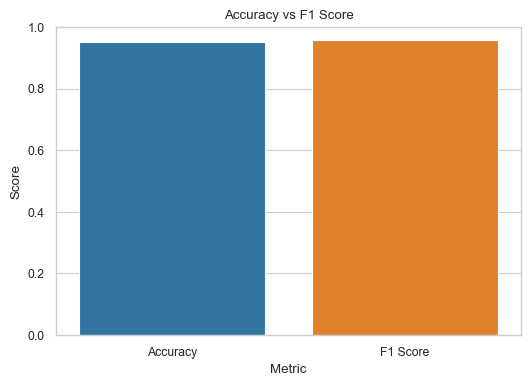

In [27]:
# Apply style
sns.set_style("whitegrid")
sns.set_context("paper")

# Compute metrics
accuracy = accuracy_score(test_df['label'], y_pred)
f1 = f1_score(test_df['label'], y_pred)

# Prepare DataFrame for plotting
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'F1 Score'],
    'Value': [accuracy, f1]
})

# Plot bar chart
plt.figure(figsize=(6, 4))
sns.barplot(x='Metric', y='Value', data=metrics_df)
plt.title("Accuracy vs F1 Score")
plt.ylim(0, 1)
plt.ylabel("Score")
plt.show()
